
# Pothole Detection using Deep Learning

## Convolutional Neural Network (CNN)
A Convolutional Neural Network (CNN) is a class of deep neural networks specifically designed for processing grid-like data, such as images. CNNs leverage convolutional layers to learn spatial hierarchies of features by applying filters that detect edges, textures, shapes, and higher-level patterns. These are typically followed by pooling layers to reduce spatial dimensions and retain the most relevant information.

In the context of pothole detection, CNNs are particularly effective due to their ability to capture local dependencies and # spatial invariance, allowing them to recognize potholes under varying lighting conditions, angles, and sizes. Their end-to-end learning capability and robustness to noise make them ideal for real-world deployment in tasks involving road surface analysis and defect localization.

In [1]:
!python --version

Python 3.10.12


## Baseline CNN Model

We built a simple yet effective baseline Convolutional Neural Network (CNN) to classify road images as either containing potholes or not. The model consists of three convolutional layers with increasing filter sizes (32, 64, and 128), each followed by max-pooling to reduce spatial dimensions. After flattening, a dense layer with 128 neurons captures high-level features, and the final sigmoid layer outputs binary predictions. The model is compiled using the Adam optimizer and binary crossentropy loss, and trained for 20 epochs to evaluate its performance on the validation set.

## Import Libraries
#### Preprocess each image by resizing and normalizing it before appending it to the list.

In [36]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

## Dataset Structure
#### Load and preprocess the images from the folders.
The dataset contains two main folders:

* **normal:**
Contains images of smooth roads from various angles and lighting conditions. These serve as examples of non-pothole scenarios.

* **potholes:**
Contains images of roads with visible potholes. These are used to help the model learn what a pothole looks like.

In [37]:
normal_path = '/kaggle/input/normal'
potholes_path = '/kaggle/input/potholes'

# Walk through the dataset directory and display structure
dataset_path = "/kaggle/input"

for root, dirs, files in os.walk(dataset_path):
    indent_level = root.replace(dataset_path, "").count(os.sep)
    indent = "  " * indent_level
    folder_name = os.path.basename(root)
    print(f"{indent}📦 {folder_name}/")
    
    for file in files[:5]:  # Show up to 5 files per folder
        file_icon = "🖼️" if file.lower().endswith(('.png', '.jpg', '.jpeg')) else "📄"
        print(f"{indent}  ├─ {file_icon} {file}")


📦 input/
  📦 normal/
    ├─ 🖼️ 208.jpg
    ├─ 🖼️ 333.jpg
    ├─ 🖼️ 45.jpg
    ├─ 🖼️ 56.jpg
    ├─ 🖼️ 89.jpg
  📦 potholes/
    ├─ 🖼️ 208.jpg
    ├─ 🖼️ 45.jpg
    ├─ 🖼️ 56.jpg
    ├─ 🖼️ 89.jpg
    ├─ 🖼️ 20.jpg


## Sample Image Display

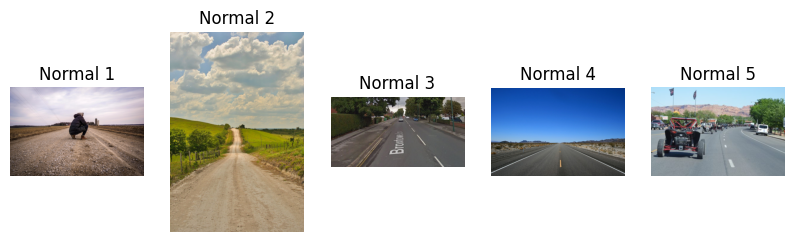

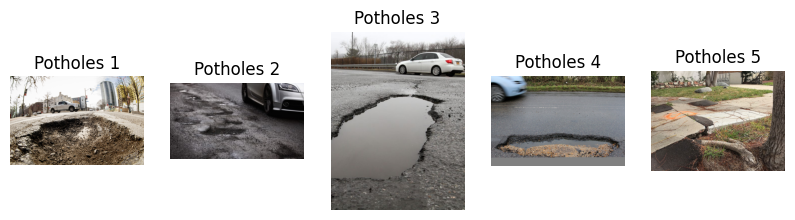

In [38]:
def show_samples(image_paths, title):
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(image_paths[:5]):
        img = Image.open(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.show()

normal_images_paths = glob(os.path.join(normal_path, '*.jpg'))
potholes_images_paths = glob(os.path.join(potholes_path, '*.jpg'))

show_samples(normal_images_paths, 'Normal')
show_samples(potholes_images_paths, 'Potholes')

## Image Preprocessing
#### Preprocess each image by resizing and normalizing it before appending it to the list.

In [39]:
IMG_SIZE = (128, 128)

def preprocess_image(img):
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    return img

def load_and_preprocess_images(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = preprocess_image(img)
            images.append(img)
            labels.append(label)
    return images, labels

normal_images, normal_labels = load_and_preprocess_images(normal_path, 0)
potholes_images, potholes_labels = load_and_preprocess_images(potholes_path, 1)

X = np.array(normal_images + potholes_images)
y = np.array(normal_labels + potholes_labels)

print("Dataset shape:", X.shape, y.shape)
print("Class distribution:", np.bincount(y))

Dataset shape: (680, 128, 128, 3) (680,)
Class distribution: [351 329]


## Class distribution

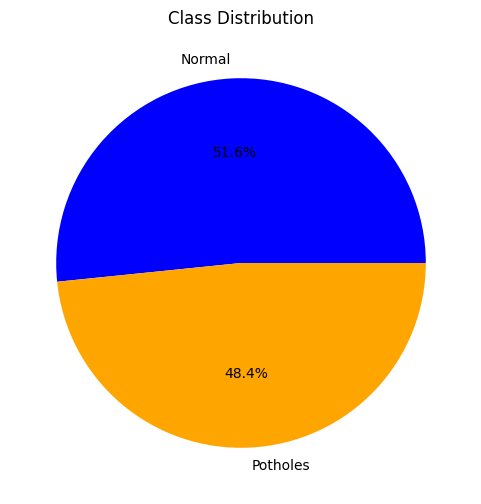

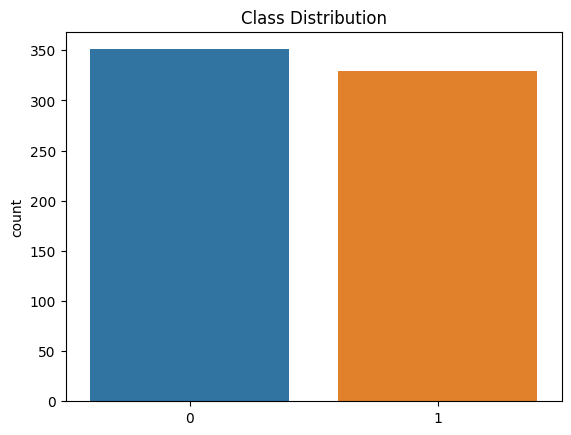

In [40]:
# Pie chart for class distribution
plt.figure(figsize=(6, 6))
plt.pie([np.sum(y == 0), np.sum(y == 1)], labels=['Normal', 'Potholes'], autopct='%1.1f%%', colors=['blue', 'orange'])
plt.title('Class Distribution')
plt.show()

# Bar plot for class distribution
sns.countplot(x=y)
plt.title('Class Distribution')
plt.show()

## Train-Test Split

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Augmentation

In [42]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

## CNN Base Model Definition

In [43]:
baseline_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Optional deeper layer (can uncomment for deeper learning)
    # layers.Conv2D(256, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

baseline_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Training

In [44]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = baseline_cnn.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=40,
    callbacks=[early_stop]
)


Epoch 1/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.5482 - loss: 0.8016 - val_accuracy: 0.6103 - val_loss: 0.6115
Epoch 2/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7969 - loss: 0.4558 - val_accuracy: 0.8309 - val_loss: 0.3652
Epoch 3/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8745 - loss: 0.2833 - val_accuracy: 0.8309 - val_loss: 0.3804
Epoch 4/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8236 - loss: 0.4301 - val_accuracy: 0.8897 - val_loss: 0.2375
Epoch 5/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8597 - loss: 0.2679 - val_accuracy: 0.7426 - val_loss: 0.6261
Epoch 6/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8676 - loss: 0.2979 - val_accuracy: 0.9485 - val_loss: 0.1595
Epoch 7/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8831 - loss: 0.2582 - val_accuracy: 0.8750 - val_loss: 0.2468
Epoch 8/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9063 - loss: 0.1993 - val_accuracy: 0.9412 - 

## Evaluation

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        86
           1       0.88      1.00      0.93        50

    accuracy                           0.95       136
   macro avg       0.94      0.96      0.95       136
weighted avg       0.95      0.95      0.95       136

Validation Accuracy: 0.9485294117647058


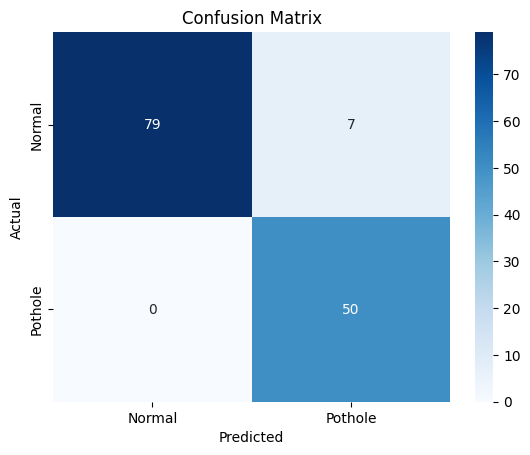

In [45]:
# Predict and evaluate
preds = (baseline_cnn.predict(X_val) > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(y_val, preds))

print("Validation Accuracy:", accuracy_score(y_val, preds))

conf_matrix = confusion_matrix(y_val, preds)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pothole'], yticklabels=['Normal', 'Pothole'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Save Model

In [46]:
baseline_cnn.save('baseline_cnn_model.h5')  # HDF5 format

## Plot the Loss Function Graph

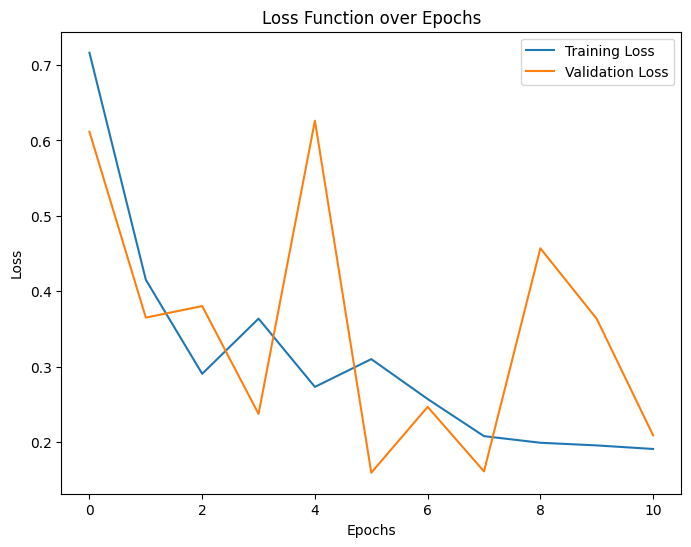

In [47]:
# Plot the training and validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Plot the Accuracy Graph

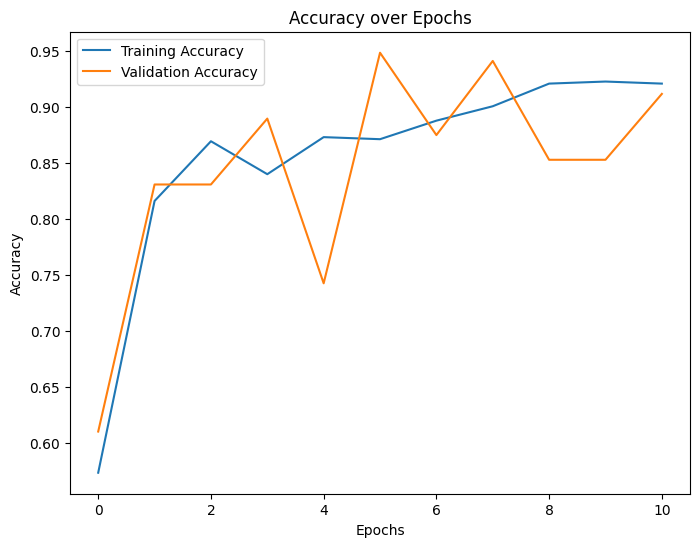

In [48]:
# Plot the training and validation accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Compact Convolutional Transformer (CCT)

Compact Convolutional Transformer (CCT) is a hybrid model that combines convolutional neural networks (CNNs) and transformer layers to improve efficiency in tasks such as image classification. The key idea behind CCT is to leverage the local feature extraction capabilities of CNNs with the global feature modeling of transformers.

### Key Components of CCT:

Convolutional Layers: These layers extract local spatial features from the input image. Unlike traditional vision transformers, which work directly with patch embeddings, CCT uses convolutional layers to reduce the computational load by creating a more compact representation of the input data.

### Transformer Layers: 

After convolutional layers extract local features, the transformer layers (multi-head self-attention) capture global dependencies across the entire input sequence (image features). This improves the model's ability to understand relationships in the image at both the local and global levels.

Classification Layers: Following the convolutional and transformer layers, fully connected (dense) layers are used for the final classification of the image into specific categories.

### Benefits of CCT:

Reduced Computational Complexity: Using CNNs for local feature extraction reduces the number of tokens the transformer needs to process, making the model more computationally efficient compared to pure transformer-based models.

Better Generalization: CCT combines the strengths of both CNNs and transformers, often resulting in better generalization across different tasks and datasets, particularly when training with smaller datasets.

**Flexibility:** CCT can be adapted for various visual tasks beyond image classification, such as object detection, segmentation, etc.

### In Short:

CCTs effectively reduce the complexity of pure transformer architectures for computer vision tasks while retaining the ability to capture both local and global information from images. 

Source: Internet

## Compact Convolutional Transformers (CCT)

#### A Custom Compact Convolutional Transformer (CCT)

**Steps to Implement Compact Convolutional Transformer (CCT)**

* Load and preprocess the dataset.
* Build the CCT model.
* Train the model.
* Evaluate using the confusion matrix and classification report.
* Plot the loss and accuracy graphs.

Found 546 images belonging to 2 classes.
Found 135 images belonging to 2 classes.


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │      51,380,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,751,553 (197.42 MB)

 Trainable params: 51,751,553 (197.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 598ms/step - accuracy: 0.5467 - loss: 1.9808 - val_accuracy: 0.7185 - val_loss: 0.5410
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 370ms/step - accuracy: 0.7697 - loss: 0.4684 - val_accuracy: 0.8444 - val_loss: 0.4125
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 327ms/step - accuracy: 0.8550 - loss: 0.3405 - val_accuracy: 0.8296 - val_loss: 0.3977
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 409ms/step - accuracy: 0.8362 - loss: 0.3708 - val_accuracy: 0.8296 - val_loss: 0.4676
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 393ms/step - accuracy: 0.8884 - loss: 0.2547 - val_accuracy: 0.8444 - val_loss: 0.5043
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step - accuracy: 0.9145 - loss: 0.2277 - val_accuracy: 0.8148 - val_loss: 0.4961
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 324ms/step - accuracy: 0.9008 - loss: 0.2886 - val_accuracy: 0.8148 - val_loss: 0.4815
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step - accuracy: 0.9330 - loss: 0.1904 - val_accuracy:

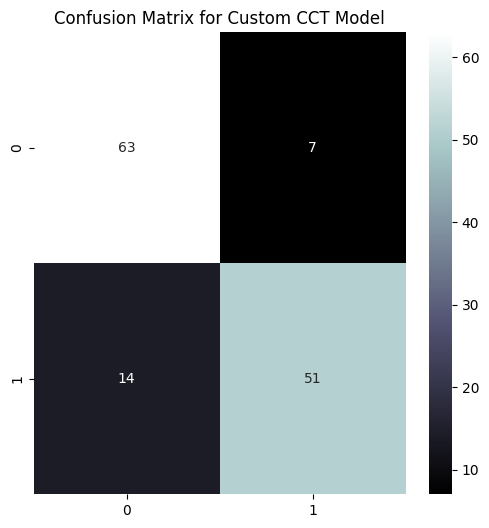

Classification Report for Custom CCT Model:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        70
           1       0.88      0.78      0.83        65

    accuracy                           0.84       135
   macro avg       0.85      0.84      0.84       135
weighted avg       0.85      0.84      0.84       135



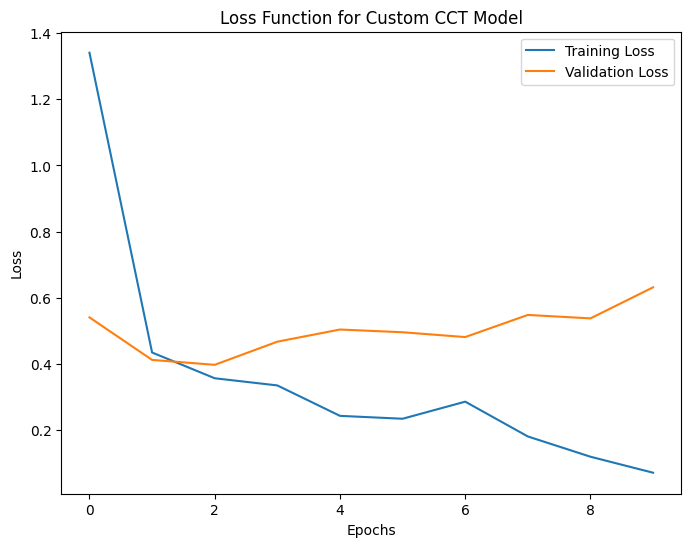

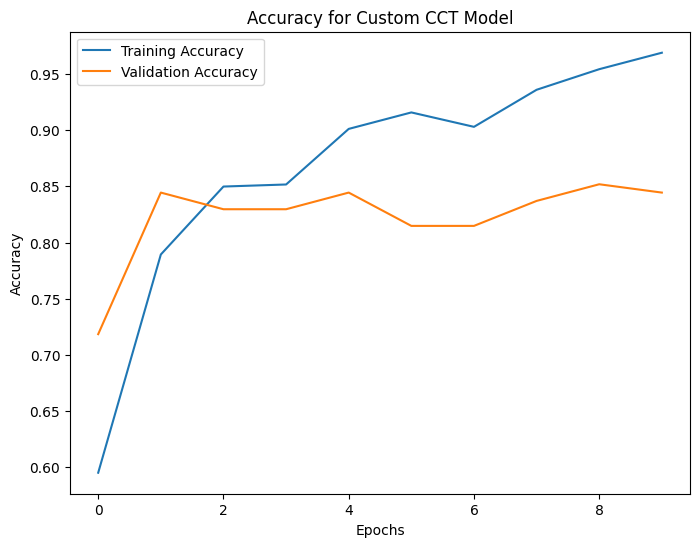

In [33]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
normal_path = '/kaggle/input/normal'
potholes_path = '/kaggle/input/potholes'

# Image preprocessing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen = datagen.flow_from_directory('/kaggle/input/',
                                        target_size=(224, 224),
                                        batch_size=32,
                                        class_mode='binary',
                                        subset='training',
                                        shuffle=True)

val_gen = datagen.flow_from_directory('/kaggle/input/',
                                      target_size=(224, 224),
                                      batch_size=32,
                                      class_mode='binary',
                                      subset='validation',
                                      shuffle=False)

# Define a custom CCT model using Keras
def create_custom_cct_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    
    # Convolutional layers to extract local features
    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    
    x = tf.keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    
    x = tf.keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    
    # Flatten and dense layers for classification
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Create model
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Build and compile the CCT model
custom_cct_model = create_custom_cct_model()

# Model summary
custom_cct_model.summary()

# Train the model
history = custom_cct_model.fit(train_gen, validation_data=val_gen, epochs=10)

# Predictions
val_pred = custom_cct_model.predict(val_gen)
val_pred_labels = (val_pred > 0.5).astype(int)
y_true = val_gen.classes

# Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, val_pred_labels)
cr = classification_report(y_true, val_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='bone')
plt.title('Confusion Matrix for Custom CCT Model')
plt.show()

# Print classification report
print(f"Classification Report for Custom CCT Model:\n{cr}")

# Plot Loss Function Graph
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function for Custom CCT Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy Graph
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy for Custom CCT Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [4]:
# Save the trained model
custom_cct_model.save('custom_cct_model.h5')


Convolutional Layers: We use 3 convolutional layers followed by max-pooling to extract local features from the input images.

Fully Connected Layers: After flattening, the model passes the features through a dense layer with dropout to prevent overfitting.

Binary Classification: The output layer uses a sigmoid activation function for binary classification.

Training and Validation: The model is trained for 10 epochs, and we plot the loss and accuracy graphs.

Evaluation: The confusion matrix and classification report are generated for detailed model evaluation.